## Deep Learning: Final Project


### Imports


In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import norm
from scipy import stats
from scipy.special import comb
import matplotlib.pyplot as plt
import seaborn as sns
from warnings import filterwarnings
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

In [ ]:
pd.set_option('display.max_columns', None)  # or 1000
pd.set_option('display.max_rows', None)  # or 1000
pd.set_option('display.max_colwidth', -1)  # or 199

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### 1. Functions needed:

In [ ]:
def get_ticker_data(ticker, timesteps, start_date, end_date, onehot, isGeneric):
    # Get data on this ticker
    tickerData = yf.Ticker(ticker)

    # Get the historical prices for this ticker
    tickerDf = tickerData.history(period='1d', start=start_date, end=end_date)
    tickerDf = tickerDf.drop(columns=["Dividends","Stock Splits"])
    
    # Data cleaning and Feature Scaling Normalization
    tickerDf.isna().any()
    sc = MinMaxScaler(feature_range = (0, 1))
    training_set_scaled = sc.fit_transform(tickerDf)
    
    # Creating a data structure with timesteps and 1 output
    X = []
    y = []
    for i in range(timesteps, tickerDf.shape[0]):
        t = training_set_scaled[i-timesteps:i, 0]
        if isGeneric:
            for j in onehot:
                t = np.append(t,j)
        X.append(t)
        y.append(training_set_scaled[i, 0])
   
    X, y = np.array(X), np.array(y)
    
    # Reshaping
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))
    # Split the data into train and test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
    return X_train, X_test, y_train, y_test

In [ ]:
def build_rnn(X_train,y_train, epochs, batch_size, dropout, rnn, first_stage):
    if first_stage:
        # Initialising the RNN
        rnn = Sequential()

        # Adding the first LSTM layer and some Dropout regularisation
        rnn.add(LSTM(units = 50, return_sequences = True, 
                     input_shape = (X_train.shape[1], 1)))
        rnn.add(Dropout(dropout))

        # Adding a second LSTM layer and some Dropout regularisation
        rnn.add(LSTM(units = 50, return_sequences = True))
        rnn.add(Dropout(dropout))

        # Adding a third LSTM layer and some Dropout regularisation
        rnn.add(LSTM(units = 50, return_sequences = True))
        rnn.add(Dropout(dropout))

        # Adding a fourth LSTM layer and some Dropout regularisation
        rnn.add(LSTM(units = 50))
        rnn.add(Dropout(dropout))

        # Adding the output layer
        rnn.add(Dense(units = 1))

        rnn.compile(optimizer = 'adam', loss = 'mean_squared_error')

    # Fitting the RNN to the Training set
    rnn.fit(X_train, y_train, epochs = epochs, batch_size = batch_size)

    return rnn

In [ ]:
def monotonicity_list(lst):
    ml = [1]
    for i in range(1,len(lst)):
        if lst[i-1] <= lst[i]:
            ml.append(1)
        else:
            ml.append(0)
    return ml

### 2. Building Specific RNN models:

In [ ]:
file_path = '/content/drive/MyDrive/Colab Notebooks/Deep Learning/FTSE100_info.csv'
FTSE100_df = pd.read_csv(file_path)
FTSE100_df.head(10)

Company Name Tickers                           Sector
0  Admiral Group             ADM     Nonlife Insurance              
1  Anglo American plc        AAL     Mining                         
2  Antofagasta               ANTO    Mining                         
3  Ashtead Group             AHT     Support Services               
4  Associated British Foods  ABF     Food Producers                 
5  AstraZeneca               AZN     Pharmaceuticals & Biotechnology
6  Auto Trader Group         AUTO    Media                          
7  Avast                     AVST    Software & Computer Services   
8  Aveva                     AVV     Software & Computer Services   
9  Aviva                     AV.     Life Insurance

In [ ]:
# Get tickers list
tickers_list = FTSE100_df.values[:, 1:2]
tickers_list = tickers_list.reshape(tickers_list.shape[0])

# Defining the parameters for the get data function
start='2000-1-1' 
end='2020-12-31'
timesteps = 5
data_list = []
# Get available data for each ticker
for ticker in tickers_list:
    try:
        X_train, X_test, y_train, y_test = get_ticker_data(ticker, timesteps, start, end, False, False)
        data_list.append({"Name":ticker, "X_train":X_train, "X_test":X_test, "y_train":y_train, "y_test":y_test})
    except:
        continue

- ANTO: No data found, symbol may be delisted
- AVV: No data found, symbol may be delisted
- AV.: No data found, symbol may be delisted
- BA.: No data found, symbol may be delisted
- BARC: No data found, symbol may be delisted
- BDEV: No data found, symbol may be delisted
- BP.: No data found, symbol may be delisted
- BATS: No data found for this date range, symbol may be delisted
- BT-A: No data found, symbol may be delisted
- BNZL: No data found, symbol may be delisted
- BRBY: No data found, symbol may be delisted
- CCH: No data found, symbol may be delisted
- CRDA: No data found for this date range, symbol may be delisted
- ENT: No data found, symbol may be delisted
- EXPN: No data found, symbol may be delisted
- FERG: No data found, symbol may be delisted
- GLEN: No data found, symbol may be delisted
- HLMA: No data found, symbol may be delisted
- HSBA: No data found, symbol may be delisted
- INF: No data found, symbol may be delisted
- ICP: No data found for this date range, symbo

#### Train RNN

In [ ]:
temp = data_list.copy()
for i,ticker in enumerate(data_list):
    print("Training RNN for:", ticker["Name"])
    rnn = build_rnn(X_train=ticker["X_train"], y_train=ticker["y_train"], epochs=10, batch_size=32, dropout=0.2, rnn=False, first_stage=True)
    temp[i]["RNN"] = rnn
    print("\n")
data_list = temp

Training RNN for: ADM
Epoch 1/10
132/132 [==============================] - 9s 14ms/step - loss: 0.0497
Epoch 2/10
132/132 [==============================] - 2s 14ms/step - loss: 0.0021
Epoch 3/10
132/132 [==============================] - 2s 13ms/step - loss: 0.0018
Epoch 4/10
132/132 [==============================] - 2s 14ms/step - loss: 0.0016
Epoch 5/10
132/132 [==============================] - 2s 13ms/step - loss: 0.0016
Epoch 6/10
132/132 [==============================] - 2s 14ms/step - loss: 0.0015
Epoch 7/10
132/132 [==============================] - 2s 13ms/step - loss: 0.0014
Epoch 8/10
132/132 [==============================] - 2s 14ms/step - loss: 0.0013
Epoch 9/10
132/132 [==============================] - 2s 14ms/step - loss: 0.0013
Epoch 10/10
132/132 [==============================] - 2s 14ms/step - loss: 0.0012


Training RNN for: AAL
Epoch 1/10
96/96 [==============================] - 8s 13ms/step - loss: 0.0859
Epoch 2/10
96/96 [==============================] - 2

#### Test RNN

In [ ]:
temp = data_list.copy()
for i,ticker in enumerate(data_list):
    rnn = ticker["RNN"]
    X_test = ticker["X_test"]
    pred = rnn.predict(X_test)
    temp[i]["Prediction"] = pred
data_list = temp

#### Show Results:

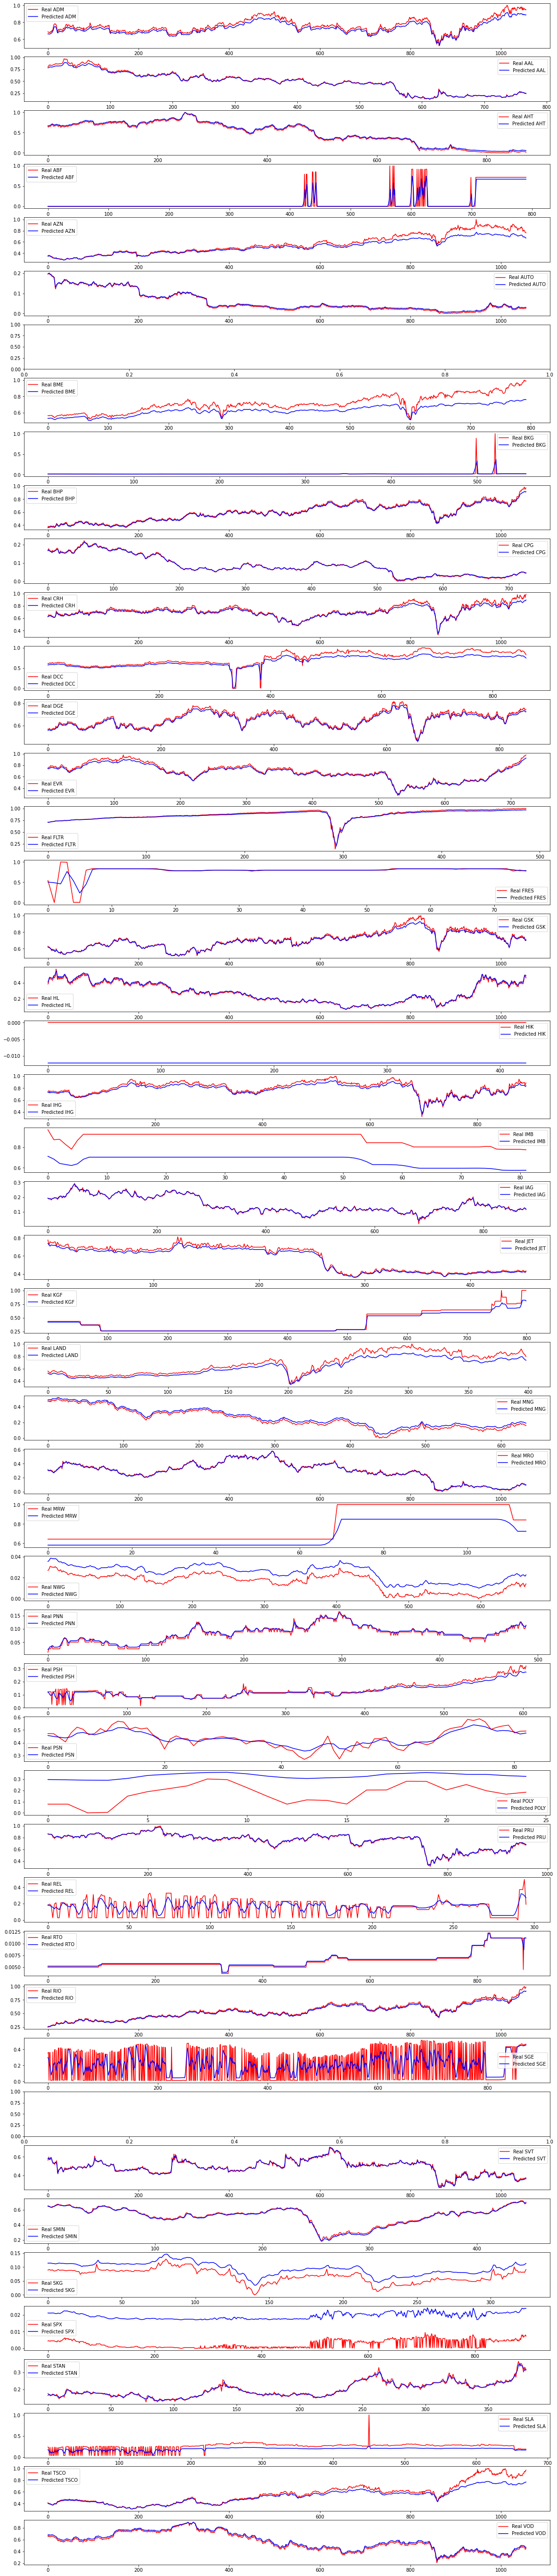

In [37]:
fig, axes = plt.subplots(48,1, figsize=(20,100))
temp = data_list.copy()
for row in range(48):
    
    ticker_name = temp[row]['Name']
    
    X_test = temp[row]['X_test']
    real_stock_price = X_test[:, 1:2].reshape(X_test.shape[0],1)
    predicted_stock_price = temp[row]['Prediction']
    
    ml_real = monotonicity_list(real_stock_price)
    ml_pred = monotonicity_list(predicted_stock_price)

    t = np.logical_xor(ml_real,ml_pred)
    col=[]
    for i in range(0,len(t)):
        if t[i]<0.5:
            col.append('Black') 
        else:
            col.append('Green') 
    
    unique, counts = np.unique(t, return_counts=True)
    
    # if ticker_name != "AVST" and ticker_name != "SGRO":
    try:
        temp[row]['Lead Score'] = counts[0]/(counts[0]+counts[1])
        axes[row].plot(real_stock_price, color = 'red', label = 'Real '+ticker_name)
        axes[row].plot(predicted_stock_price, color = 'blue', label = 'Predicted '+ticker_name)
        # axes[row].scatter(np.arange(1,t.shape[0]+1),t, c=col, alpha=0.5,s=10 ,label = 'Monotonicity') 
        # axes[row].text(t.shape[0],1,'Count Incorrect:'+str(counts[1]))
        # axes[row].text(t.shape[0],0,'Count Correct:'+str(counts[0]))
        
        axes[row].legend()
    except:
        continue
    
plt.show()
data_list = temp

### 3. Building Generic RNN models:

In [ ]:
file_path = '/content/drive/MyDrive/Colab Notebooks/Deep Learning/FTSE100_info.csv'
FTSE100_df = pd.read_csv(file_path)
FTSE100_df.head()

Company Name Tickers             Sector
0  Admiral Group             ADM     Nonlife Insurance
1  Anglo American plc        AAL     Mining           
2  Antofagasta               ANTO    Mining           
3  Ashtead Group             AHT     Support Services 
4  Associated British Foods  ABF     Food Producers

In [ ]:
# Check how many sectors we have
FTSE100_df['Sector'].nunique()

40

In [36]:
# Create Onehot vector
onehot_lists = pd.get_dummies(FTSE100_df.Sector, prefix='Sector')
onehot_lists = onehot_lists.values
onehot_lists = onehot_lists.astype(np.float64)
print(onehot_lists[0])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [ ]:
# Get tickers list
tickers_list = FTSE100_df.values[:, 1:2]
tickers_list = tickers_list.reshape(tickers_list.shape[0])

# Defining the parameters for the get data function
start='2000-1-1' 
end='2020-12-31'
timesteps = 5
data_list_gen = []

# Get available data for each ticker
for i,ticker in enumerate(tickers_list):  
    try:
        X_train, X_test, y_train, y_test = get_ticker_data(ticker=ticker, timesteps=timesteps, start_date=start, end_date=end, onehot=onehot_lists[i], isGeneric=True)
        data_list_gen.append({"Name":ticker, "X_train":X_train, "X_test":X_test, "y_train":y_train, "y_test":y_test})
    except:
        continue                   
    

- ANTO: No data found, symbol may be delisted
- AVV: No data found, symbol may be delisted
- AV.: No data found, symbol may be delisted
- BA.: No data found, symbol may be delisted
- BARC: No data found, symbol may be delisted
- BDEV: No data found, symbol may be delisted
- BP.: No data found, symbol may be delisted
- BATS: No data found for this date range, symbol may be delisted
- BT-A: No data found, symbol may be delisted
- BNZL: No data found, symbol may be delisted
- BRBY: No data found, symbol may be delisted
- CCH: No data found, symbol may be delisted
- CRDA: No data found for this date range, symbol may be delisted
- ENT: No data found, symbol may be delisted
- EXPN: No data found, symbol may be delisted
- FERG: No data found, symbol may be delisted
- GLEN: No data found, symbol may be delisted
- HLMA: No data found, symbol may be delisted
- HSBA: No data found, symbol may be delisted
- INF: No data found, symbol may be delisted
- ICP: No data found for this date range, symbo

In [ ]:
# Build generic RNN
for i,ticker in enumerate(data_list_gen):
    print("Training RNN for:", ticker["Name"])
    if i == 0:
        rnn = build_rnn(X_train=ticker["X_train"], y_train=ticker["y_train"], epochs=10, batch_size=32, dropout=0.2, rnn=False, first_stage=True)

    else:
        rnn = build_rnn(X_train=ticker["X_train"], y_train=ticker["y_train"], epochs=10, batch_size=32, dropout=0.2, rnn=rnn, first_stage=False)
    print("\n")


Training RNN for: ADM
Epoch 1/10
132/132 [==============================] - 22s 88ms/step - loss: 0.0426
Epoch 2/10
132/132 [==============================] - 12s 89ms/step - loss: 0.0028
Epoch 3/10
132/132 [==============================] - 12s 88ms/step - loss: 0.0013
Epoch 4/10
132/132 [==============================] - 12s 88ms/step - loss: 0.0014
Epoch 5/10
132/132 [==============================] - 12s 90ms/step - loss: 0.0014
Epoch 6/10
132/132 [==============================] - 12s 88ms/step - loss: 0.0013
Epoch 7/10
132/132 [==============================] - 11s 87ms/step - loss: 0.0013
Epoch 8/10
132/132 [==============================] - 12s 88ms/step - loss: 0.0012
Epoch 9/10
132/132 [==============================] - 12s 88ms/step - loss: 0.0013
Epoch 10/10
132/132 [==============================] - 12s 88ms/step - loss: 0.0012


Training RNN for: AAL
Epoch 1/10
96/96 [==============================] - 8s 87ms/step - loss: 0.0020
Epoch 2/10
96/96 [=========================

#### Test RNN

In [ ]:
temp = data_list_gen.copy()
for i,ticker in enumerate(data_list_gen):
    X_test = ticker["X_test"]
    pred = rnn.predict(X_test)
    temp[i]["Prediction"] = pred
data_list_gen = temp

#### Show Results:

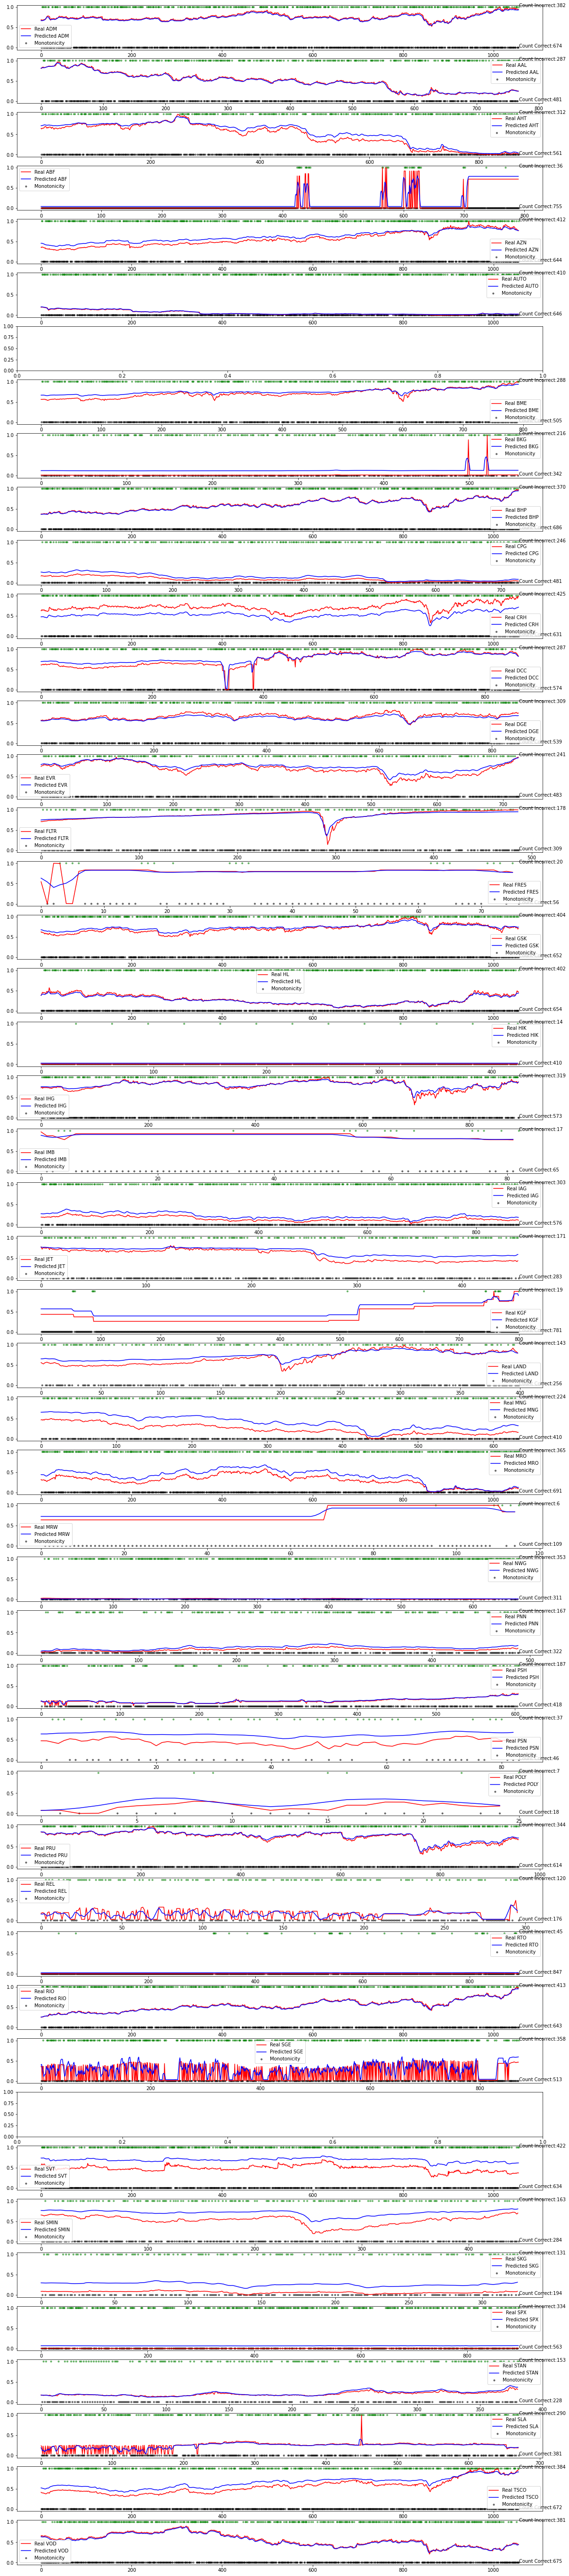

In [ ]:
fig, axes = plt.subplots(48,1, figsize=(20,100))
temp = data_list_gen.copy()
for row in range(48):
    
    ticker_name = temp[row]['Name']
    
    X_test = temp[row]['X_test']
    real_stock_price = X_test[:, 1:2].reshape(X_test.shape[0],1)
    predicted_stock_price = temp[row]['Prediction']
    
    ml_real = monotonicity_list(real_stock_price)
    ml_pred = monotonicity_list(predicted_stock_price)

    t = np.logical_xor(ml_real,ml_pred)
    col=[]
    for i in range(0,len(t)):
        if t[i]<0.5:
            col.append('Black') 
        else:
            col.append('Green') 
    
    unique, counts = np.unique(t, return_counts=True)
    
    # if ticker_name != "AVST" and ticker_name != "SGRO":
    try:
        temp[row]['Lead Score'] = counts[0]/(counts[0]+counts[1])
        axes[row].plot(real_stock_price, color = 'red', label = 'Real '+ticker_name)
        axes[row].plot(predicted_stock_price, color = 'blue', label = 'Predicted '+ticker_name)
        axes[row].scatter(np.arange(1,t.shape[0]+1),t, c=col, alpha=0.5,s=10 ,label = 'Monotonicity') 
        axes[row].text(t.shape[0],1,'Count Incorrect:'+str(counts[1]))
        axes[row].text(t.shape[0],0,'Count Correct:'+str(counts[0]))
        
        axes[row].legend()
    except:
        continue
    
plt.show()
data_list_gen = temp

#### 4. Comparing results:

In [ ]:
results = []
for ticker_gen, ticker in zip(data_list_gen, data_list):
    try:
        results.append({"Name": ticker_gen["Name"], "Specific RNN Accu":ticker_gen["Lead Score"], "Generic RNN Accu":ticker["Lead Score"]})
    except:
        continue
df_res = pd.DataFrame(results)
df_res.head(10)

Name  Specific RNN Accu  Generic RNN Accu
0  ADM   0.638258           0.679924        
1  AAL   0.626302           0.671875        
2  AHT   0.642612           0.698740        
3  ABF   0.954488           0.964602        
4  AZN   0.609848           0.665720        
5  AUTO  0.611742           0.625000        
6  BME   0.636822           0.658260        
7  BKG   0.612903           0.623656        
8  BHP   0.649621           0.646780        
9  CPG   0.661623           0.664374

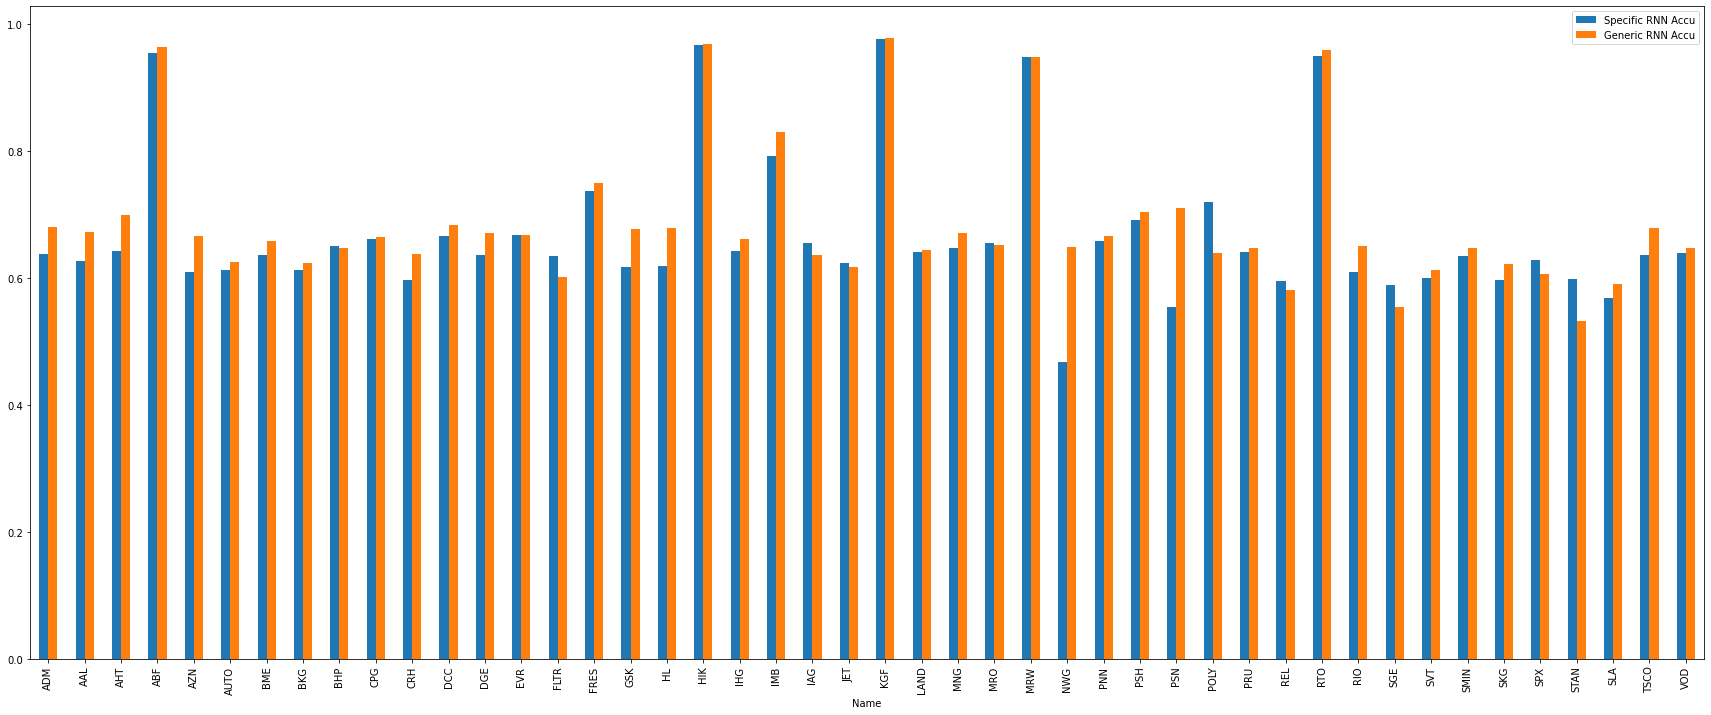

In [ ]:

df_res.plot(x="Name", y=["Specific RNN Accu", "Generic RNN Accu"], kind="bar",figsize=(30,12))
plt.show()

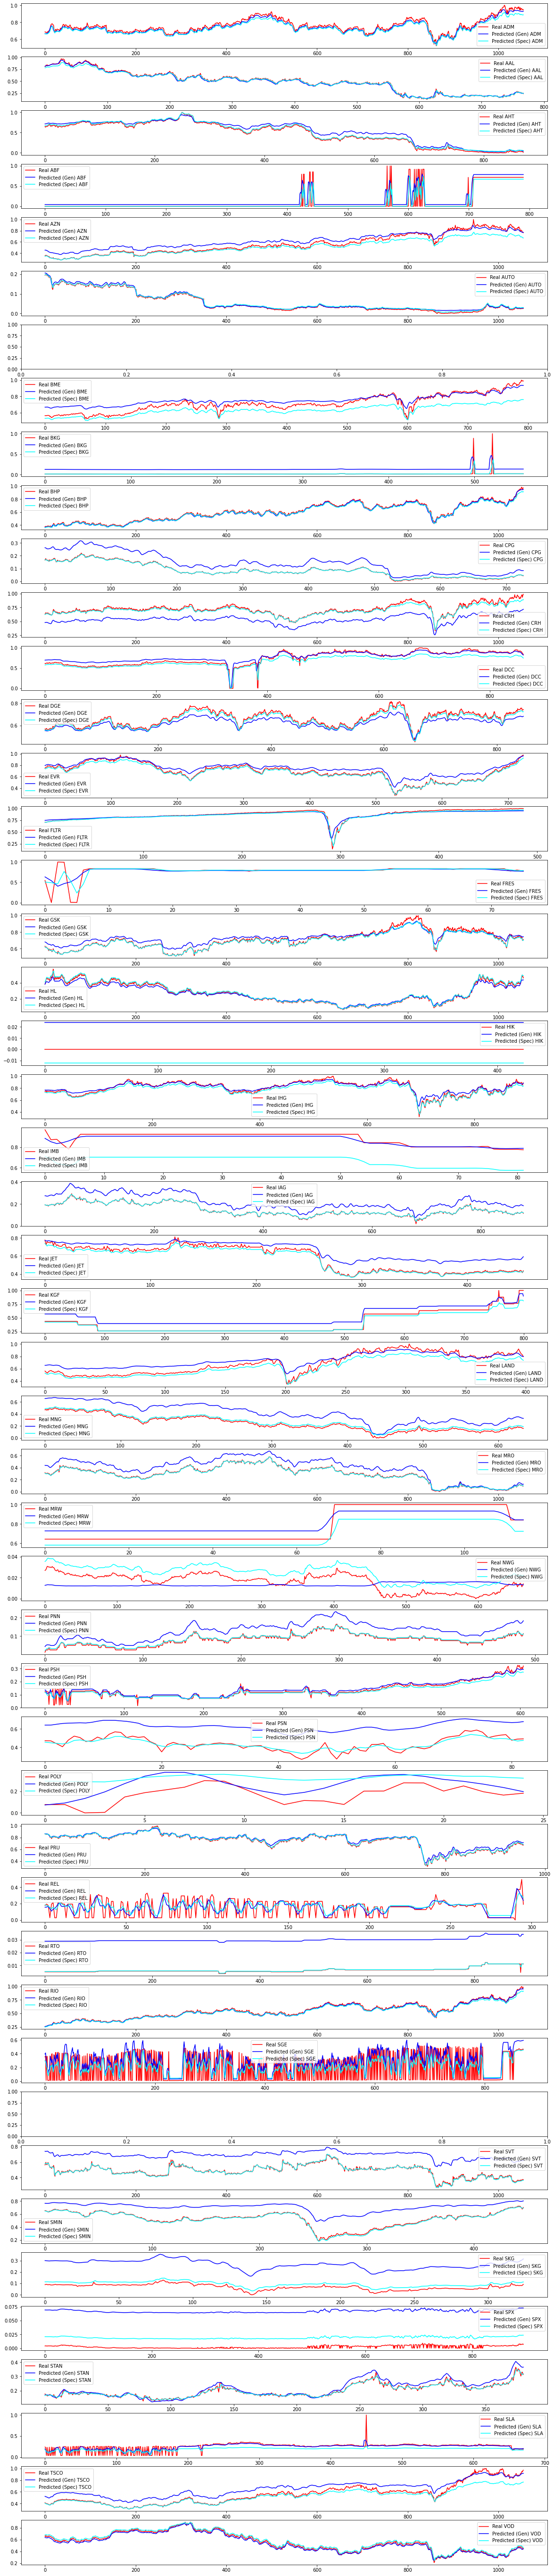

In [39]:
fig, axes = plt.subplots(48,1, figsize=(20,100))
temp = data_list_gen.copy()
for row in range(48):
    
    ticker_name = temp[row]['Name']
    
    X_test = temp[row]['X_test']
    real_stock_price = X_test[:, 1:2].reshape(X_test.shape[0],1)
    predicted_stock_price = temp[row]['Prediction']
    predicted_stock_price_spec = data_list[row]['Prediction']
    ml_real = monotonicity_list(real_stock_price)
    ml_pred = monotonicity_list(predicted_stock_price)

    t = np.logical_xor(ml_real,ml_pred)
    col=[]
    for i in range(0,len(t)):
        if t[i]<0.5:
            col.append('Black') 
        else:
            col.append('Green') 
    
    unique, counts = np.unique(t, return_counts=True)
    
    # if ticker_name != "AVST" and ticker_name != "SGRO":
    try:
        temp[row]['Lead Score'] = counts[0]/(counts[0]+counts[1])
        axes[row].plot(real_stock_price, color = 'red', label = 'Real '+ticker_name)
        axes[row].plot(predicted_stock_price, color = 'blue', label = 'Predicted (Gen) '+ticker_name)
        axes[row].plot(predicted_stock_price_spec, color = 'cyan', label = 'Predicted (Spec) '+ticker_name)
        # axes[row].scatter(np.arange(1,t.shape[0]+1),t, c=col, alpha=0.5,s=10 ,label = 'Monotonicity') 
        # axes[row].text(t.shape[0],1,'Count Incorrect:'+str(counts[1]))
        # axes[row].text(t.shape[0],0,'Count Correct:'+str(counts[0]))
        
        axes[row].legend()
    except:
        continue
    
plt.show()
data_list_gen = temp